In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

In [2]:
#input_dir = 'output-files-bootstrap-test7-2d'

input_dir = 'output-files-bootstrap-test6b-2d-2a-100k'

#input_dir = 'bootstrap-simple-pdf-toy-study6b-2d-v1b'

#input_dir = 'output-files-bootstrap-test6b-2d-2a'

with open( '%s/train-and-true-samples.npy' % input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    
print('\n\n')
print(' shape of train_pts:  %s' % str(train_pts.shape))
print(' shape of true_pts:   %s' % str(true_pts.shape))
print('\n\n')






 shape of train_pts:  (100000, 2)
 shape of true_pts:   (10000, 2)





In [3]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [4]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)



 Number of feature dimensions: 2




In [5]:
with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)

<function matplotlib.pyplot.show(close=None, block=None)>

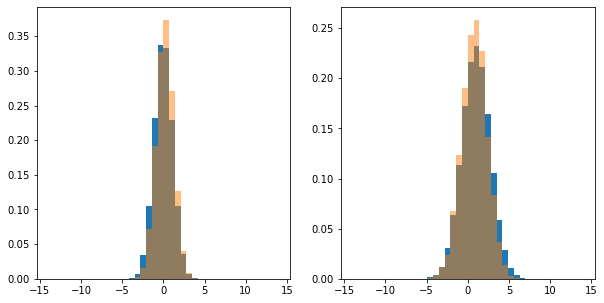

In [6]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))



hmin=-5
hmax=5


hmin=-14
hmax=14

hbins=40


for i in range(ndim) :
        ax[i].hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

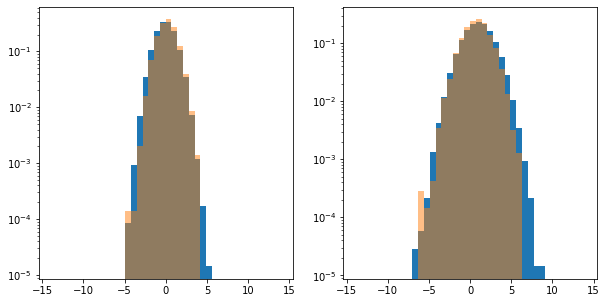

In [7]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins=40


for i in range(ndim) :
        ax[i].hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
        ax[i].set_yscale('log')
    
plt.show

In [8]:
with open( "%s/omnifold-output-weights.npy" % input_dir,'rb') as f :
    main_sample_omnifold_weights = np.load(f)


In [9]:
main_sample_omnifold_weights = np.clip( main_sample_omnifold_weights, 1e-11, 1e11)

<function matplotlib.pyplot.show(close=None, block=None)>

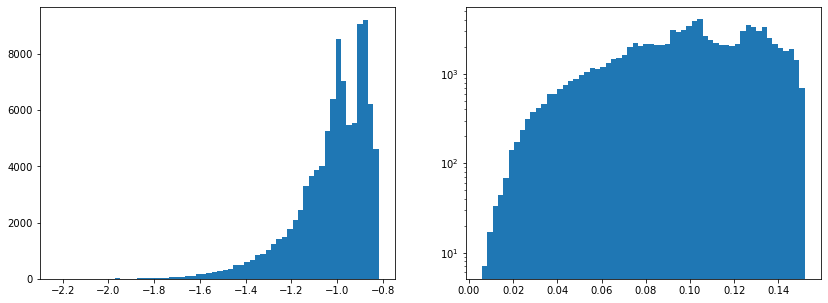

In [10]:
fig,ax = plt.subplots( 1, 2, figsize=(2*7,5))

hbins = 60
ax[0].hist( np.log10(main_sample_omnifold_weights), bins=hbins)
ax[1].hist( main_sample_omnifold_weights, bins=hbins)
ax[1].set_yscale('log')
plt.show

In [11]:
true_rho

array([[-0.6]])

In [12]:
true_mu.shape

(2,)

In [13]:
true_cov = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        k = ndim - j - 1
        if i == j :
            true_cov[i][j] = true_sig[i]*true_sig[i]
        elif j > i :
            print(" %d, %d, %d" % (i,j,k))
            true_cov[i][j] = true_rho[i][k] * true_sig[i] * true_sig[j]

 0, 1, 0


In [14]:
true_cov

array([[ 0.81 , -0.702],
       [ 0.   ,  1.69 ]])

In [15]:
have_fits = False

if exists( "%s/fit-results.npy" % input_dir ) :
    have_fits = True
    print("\n\n Have fit results file.\n\n")



 Have fit results file.




In [16]:
if have_fits :
    
    with open( '%s/fit-results.npy' % input_dir, 'rb' ) as f :
        fit_results_mean_val = np.load(f, allow_pickle=True )
        fit_results_mean_err = np.load(f, allow_pickle=True )
        fit_results_cov_val = np.load(f, allow_pickle=True )
        fit_results_cov_err = np.load(f, allow_pickle=True )        
        

    ave_fit_err_mean = np.zeros( ndim )

    for fi in range(ndim) :
    
        ave_fit_err_mean[fi] = np.mean( fit_results_mean_err[fi,:])
    

In [17]:
def calc_mean( weights, fi ) :
    
    mean = ( np.sum( weights * train_pts[:,fi]) ) / ( np.sum( weights ) )
    
    return mean

In [18]:
def calc_rms( weights, fi ) :
    
    x = calc_mean( weights, fi )
    xx = ( np.sum( weights * train_pts[:,fi] * train_pts[:,fi] ) ) / ( np.sum( weights ) )
    
    #print(" x = %f,  xx = %f" % (x, xx))
    
    return np.sqrt(xx - x*x)


In [19]:
def calc_cov( weights, fi1, fi2 ) :
    
    x1 = calc_mean( weights, fi1 )
    x2 = calc_mean( weights, fi2 )
    x1x2 = ( np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] ) ) / ( np.sum( weights ) )
    
    return np.sqrt( x1x2 - x1*x2 )
    

In [20]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [21]:
n_samples = 0

for fi in range(1000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 50 bootstrap samples.




In [22]:
%%time

all_mean = np.zeros( shape=(ndim,n_samples) )
all_rms = np.zeros( shape=(ndim,n_samples) )
all_cov = np.zeros( shape=(ndim,ndim,n_samples) )
all_rho = np.zeros( shape=(ndim,ndim,n_samples) )

all_weight_min = np.zeros( n_samples )
all_weight_max = np.zeros( n_samples )


si = 0

for fi in range(500) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        
        print('\n----- %s exists' % fname )
        
        with open(fname,'rb') as f :
            
            final_push_weights_scaled = np.load(f)
            print( len(final_push_weights_scaled))
            print( final_push_weights_scaled )
            print( true_pts[:,0])
            
            all_weight_min[si] = np.min( final_push_weights_scaled )
            all_weight_max[si] = np.max( final_push_weights_scaled )
            
            for fi1 in range(ndim) :
                for fi2 in range(fi1,ndim) :
                    mean_cov = calc_mean_cov( final_push_weights_scaled, fi1, fi2 )
                    all_cov[fi1,fi2,si] = mean_cov["cov_x1x2"]
                    all_cov[fi2,fi1,si] = mean_cov["cov_x1x2"]
                    if ( fi1 == fi2 ) :
                        print( "  %d %d  :  mean = %8.4f, RMS = %8.4f, cov = %8.4f" % 
                              (fi1, fi2, mean_cov["mean_x1"], mean_cov["rms1"], mean_cov["cov_x1x2"]))
                        all_mean[fi1,si] = mean_cov["mean_x1"]
                        all_rms[fi1,si] = mean_cov["rms1"]
                    else :
                        print( "  %d %d  :  rho = %8.4f,  cov = %8.4f" %
                              (fi1, fi2, mean_cov["rho12"], mean_cov["cov_x1x2"]) )
                        all_rho[fi1,fi2,si] = mean_cov["rho12"]
                        all_rho[fi2,fi1,si] = mean_cov["rho12"]
                        
        si = si + 1
        
            


----- output-files-bootstrap-test6b-2d-2a-100k/bootstrap-weights-000.npy exists
100000
[0.04687802 0.11799523 0.05866844 ... 0.08327871 0.0682585  0.08233292]
[0.34903505 0.2475683  1.79380263 ... 2.28812334 0.32411313 0.08986465]
  0 0  :  mean =   0.1716, RMS =   0.9022, cov =   0.8140
  0 1  :  rho =  -0.5772,  cov =  -0.6819
  1 1  :  mean =   0.8265, RMS =   1.3092, cov =   1.7141

----- output-files-bootstrap-test6b-2d-2a-100k/bootstrap-weights-001.npy exists
100000
[0.04852846 0.13602738 0.04786434 ... 0.09551027 0.05444359 0.09037348]
[0.34903505 0.2475683  1.79380263 ... 2.28812334 0.32411313 0.08986465]
  0 0  :  mean =   0.1973, RMS =   0.9013, cov =   0.8124
  0 1  :  rho =  -0.5788,  cov =  -0.6734
  1 1  :  mean =   0.8146, RMS =   1.2908, cov =   1.6663

----- output-files-bootstrap-test6b-2d-2a-100k/bootstrap-weights-002.npy exists
100000
[0.06732123 0.12999234 0.06747337 ... 0.07407887 0.08669627 0.07701041]
[0.34903505 0.2475683  1.79380263 ... 2.28812334 0.32411313 

<function matplotlib.pyplot.show(close=None, block=None)>

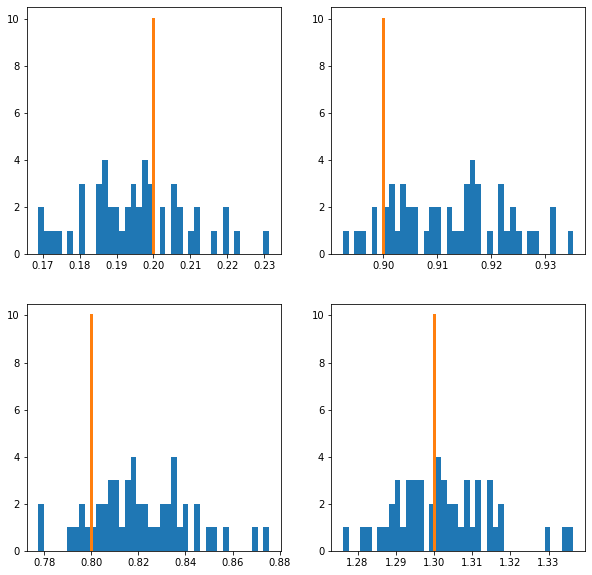

In [23]:
fig,ax = plt.subplots( ndim, 2, figsize=(2*5,ndim*5))

ymax = 10

for i in range(ndim) :
    
    ax[i][0].hist( all_mean[i], bins=40)
    ax[i][1].hist( all_rms[i], bins=40)
    
    ax[i][0].plot( (true_mu[i], true_mu[i]), (0,ymax), linewidth=3 )
    ax[i][1].plot( (true_sig[i], true_sig[i]), (0,ymax), linewidth=3 )

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

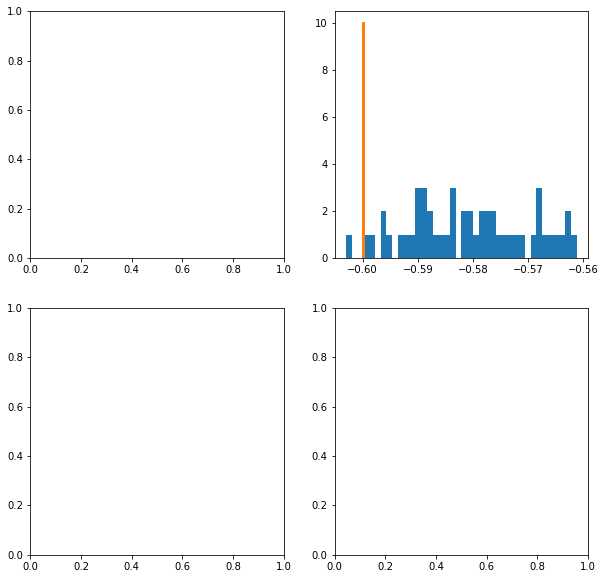

In [24]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5,ndim*5))

ymax = 10

for i in range(0,ndim-1) :
    
    for j in range(i+1,ndim) :
        
        k = ndim - j - 1
        
        ax[i][j].hist( all_rho[i,j], bins=40)
        
        ax[i][j].plot( (true_rho[i][k], true_rho[i][k]), (0, ymax), linewidth=3 )
    


plt.show

In [25]:
print('\n')

ave_mean = np.zeros( ndim )
rms_mean = np.zeros( ndim )

ave_cov = np.zeros( shape=(ndim,ndim) )
rms_cov = np.zeros( shape=(ndim,ndim) )


for fi in range(ndim) :
    
    ave_mean[fi] = np.mean( all_mean[fi] )
    ave_mean2 = np.mean( all_mean[fi]*all_mean[fi])
    rms_mean[fi] = np.sqrt( ave_mean2 - ave_mean[fi]*ave_mean[fi] )
    print("  feature %d  :  mean   ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_mean[fi], true_mu[fi], rms_mean[fi] ))
    
print('\n')

for fi in range(ndim) :
    
    ave_rms = np.mean( all_rms[fi] )
    ave_rms2 = np.mean( all_rms[fi]*all_rms[fi])
    rms_rms = np.sqrt( ave_rms2 - ave_rms*ave_rms )
    print("  feature %d  :  RMS    ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_rms, true_sig[fi], rms_rms ))
    
print('\n')

for fi1 in range(0,ndim-1) :
    for fi2 in range(fi1+1, ndim) :
        k = ndim - fi2 - 1
        ave_rho = np.mean( all_rho[fi1,fi2])
        ave_rho2 = np.mean( all_rho[fi1,fi2]*all_rho[fi1,fi2] )
        rms_rho = np.sqrt( ave_rho2 - ave_rho*ave_rho )
        print("  feature %d, %d  :  rho    ave %8.4f  (true %8.4f), rms %8.4f" % ( fi1, fi2, ave_rho, true_rho[fi1][k], rms_rho ))
        
print("\n")

for fi1 in range(0,ndim) :
    for fi2 in range(fi1,ndim) :
        ave_cov[fi1,fi2] = np.mean( all_cov[fi1][fi2] )
        ave_cov2 = np.mean( all_cov[fi1][fi2]*all_cov[fi1][fi2] )
        rms_cov[fi1,fi2] = np.sqrt( ave_cov2 - ave_cov[fi1,fi2]*ave_cov[fi1,fi2] )
        print("  feature %d, %d  :  cov    ave %8.4f  (true %8.4f), rms %8.4f" %
              (fi1, fi2, ave_cov[fi1,fi2], true_cov[fi1,fi2], rms_cov[fi1,fi2] ) )

print("\n")



  feature 0  :  mean   ave   0.1951  (true   0.2000), rms   0.0140
  feature 1  :  mean   ave   0.8210  (true   0.8000), rms   0.0207


  feature 0  :  RMS    ave   0.9124  (true   0.9000), rms   0.0102
  feature 1  :  RMS    ave   1.3023  (true   1.3000), rms   0.0126


  feature 0, 1  :  rho    ave  -0.5808  (true  -0.6000), rms   0.0108


  feature 0, 0  :  cov    ave   0.8326  (true   0.8100), rms   0.0187
  feature 0, 1  :  cov    ave  -0.6903  (true  -0.7020), rms   0.0211
  feature 1, 1  :  cov    ave   1.6962  (true   1.6900), rms   0.0328




## Save the simple direct calculation results for setting fit parameter ranges from RMS.

In [26]:
with open( '%s/simple-calc-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, ave_mean )
    np.save( f, rms_mean )
    np.save( f, ave_cov )
    np.save( f, rms_cov )

In [27]:
if have_fits :
    
    for si in range( n_samples ) :
        
        for fi in range( 1,2 ) :
            print("  sample %3d :  mean%d   calc  %8.4f  fit %8.4f" % 
                  (si, fi, all_mean[fi,si], fit_results_mean_val[fi,si]))

  sample   0 :  mean1   calc    0.8265  fit   0.8265
  sample   1 :  mean1   calc    0.8146  fit   0.8146
  sample   2 :  mean1   calc    0.8327  fit   0.8327
  sample   3 :  mean1   calc    0.8220  fit   0.8220
  sample   4 :  mean1   calc    0.8108  fit   0.8108
  sample   5 :  mean1   calc    0.7999  fit   0.7999
  sample   6 :  mean1   calc    0.8519  fit   0.8518
  sample   7 :  mean1   calc    0.8182  fit   0.8182
  sample   8 :  mean1   calc    0.8075  fit   0.8075
  sample   9 :  mean1   calc    0.8458  fit   0.8458
  sample  10 :  mean1   calc    0.8358  fit   0.8358
  sample  11 :  mean1   calc    0.8326  fit   0.8326
  sample  12 :  mean1   calc    0.8183  fit   0.8183
  sample  13 :  mean1   calc    0.8091  fit   0.8091
  sample  14 :  mean1   calc    0.8459  fit   0.8459
  sample  15 :  mean1   calc    0.7776  fit   0.7776
  sample  16 :  mean1   calc    0.8149  fit   0.8149
  sample  17 :  mean1   calc    0.8177  fit   0.8177
  sample  18 :  mean1   calc    0.8303  fit   

   0 : x axis limits:  0.166, 0.234    y axis limits  0.166, 0.234
   1 : x axis limits:  0.773, 0.880    y axis limits  0.773, 0.880


<function matplotlib.pyplot.show(close=None, block=None)>

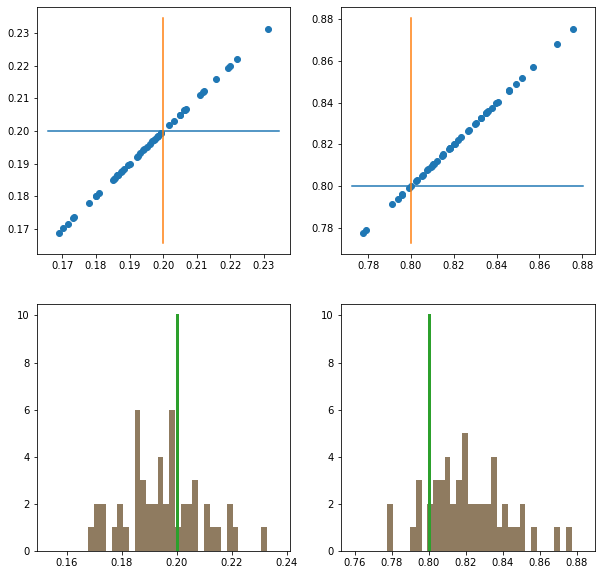

In [28]:
fig,ax = plt.subplots( 2, ndim, figsize=(5*ndim,5*2))

hbins=40
hmax = 10

for fi in range(ndim) :
    ax[0][fi].scatter( all_mean[fi,:], fit_results_mean_val[fi,:])
    xlow, xhigh = ax[0][fi].get_xlim()
    ylow, yhigh = ax[0][fi].get_ylim()
    print("  %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi, xlow, xhigh, ylow, yhigh))
    ax[0][fi].plot( (xlow, xhigh), (true_mu[fi], true_mu[fi]))
    ax[0][fi].plot( (true_mu[fi], true_mu[fi]), (ylow, yhigh))
    

    ax[1][fi].hist( fit_results_mean_val[fi,:], bins=hbins, 
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    ax[1][fi].hist( all_mean[fi,:], bins=hbins, alpha=0.5,
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    ax[1][fi].plot( (true_mu[fi],true_mu[fi]),(0,hmax), linewidth=3)
    

plt.show

   0,  0 : x axis limits:  0.793, 0.879    y axis limits  0.793, 0.879
   0,  1 : x axis limits:  -0.736, -0.649    y axis limits  -0.736, -0.649
   1,  1 : x axis limits:  1.621, 1.794    y axis limits  1.621, 1.794


<function matplotlib.pyplot.show(close=None, block=None)>

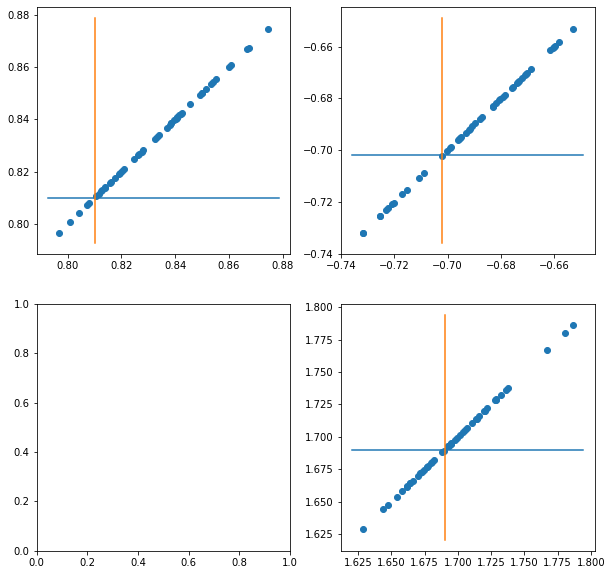

In [29]:
fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        ax[fi1][fi2].scatter( all_cov[fi1,fi2,:], fit_results_cov_val[fi1,fi2,:])
        xlow, xhigh = ax[fi1][fi2].get_xlim()
        ylow, yhigh = ax[fi1][fi2].get_ylim()
        print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi1, fi2, xlow, xhigh, ylow, yhigh))
        ax[fi1][fi2].plot((xlow,xhigh),(true_cov[fi1][fi2], true_cov[fi1][fi2]))
        ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(ylow,yhigh))

plt.show

   0,  0 : x axis limits:  0.771, 0.894    y axis limits  0.000, 6.300
   0,  1 : x axis limits:  -0.760, -0.621    y axis limits  0.000, 4.200
   1,  1 : x axis limits:  1.588, 1.804    y axis limits  0.000, 6.300


<function matplotlib.pyplot.show(close=None, block=None)>

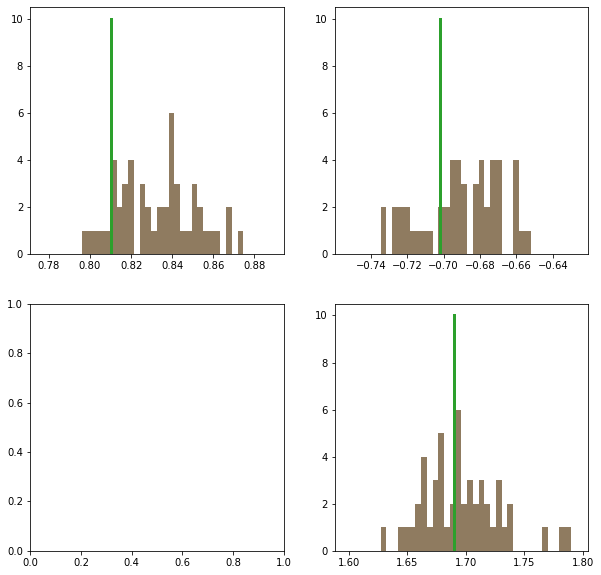

In [30]:
fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

hbins=40
hmax=10

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        ax[fi1][fi2].hist( fit_results_cov_val[fi1,fi2,:], bins=hbins, 
                         range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
        ax[fi1][fi2].hist( all_cov[fi1,fi2,:], bins=hbins, alpha=0.5,
                         range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
        xlow, xhigh = ax[fi1][fi2].get_xlim()
        ylow, yhigh = ax[fi1][fi2].get_ylim()
        print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi1, fi2, xlow, xhigh, ylow, yhigh))

        ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(0,hmax), linewidth=3)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

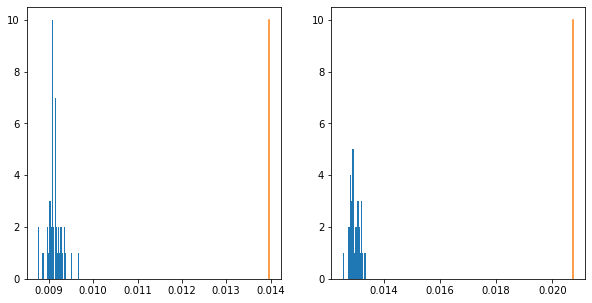

In [31]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins = 40
hmax = 10

for fi in range(ndim) :
    ax[fi].hist( fit_results_mean_err[fi,:], bins=hbins )
    ax[fi].plot( (rms_mean[fi], rms_mean[fi]), (0,hmax) )
    
    
plt.show

## Bootstrap error compared with average fit error

In [32]:
for fi in range(ndim) :
    
    print("  feature %d mean:   rms bootstraps %8.4f,  ave fit err %8.4f    ratio  %8.2f"
         % (fi, rms_mean[fi], ave_fit_err_mean[fi], rms_mean[fi] / ave_fit_err_mean[fi] ))

  feature 0 mean:   rms bootstraps   0.0140,  ave fit err   0.0091    ratio      1.53
  feature 1 mean:   rms bootstraps   0.0207,  ave fit err   0.0130    ratio      1.59


## Look for outliers in feature coords and weights

In [33]:
for fi in range( ndim ) :
    
    print( "  feature %2d :  min %12f   max %12f " % ( fi, np.min(train_pts[:,fi]), np.max(train_pts[:,fi])) )

  feature  0 :  min    -4.276633   max     4.330136 
  feature  1 :  min    -5.870869   max     7.616782 


In [34]:
for si in range( n_samples ) :
    
    max_delta_mean = 0
    for fi in range(ndim) :
        delta = fit_results_mean_val[fi,si] - all_mean[fi,si] 
        if np.abs(delta) > max_delta_mean :
            max_delta_mean = delta
        
    print("  %3d : weight range  %12g  to %12f ,   max delta mean  %12f"
         % (si, all_weight_min[si], all_weight_max[si], max_delta_mean ))

    0 : weight range    0.00175071  to     0.364907 ,   max delta mean     -0.000002
    1 : weight range   0.000589918  to     0.837807 ,   max delta mean     -0.000001
    2 : weight range    0.00030122  to     1.891740 ,   max delta mean      0.000002
    3 : weight range   0.000262979  to     2.846634 ,   max delta mean      0.000002
    4 : weight range   0.000459724  to     0.553482 ,   max delta mean      0.000006
    5 : weight range   7.91741e-05  to     0.794096 ,   max delta mean      0.000006
    6 : weight range   2.87377e-05  to     0.579593 ,   max delta mean      0.000031
    7 : weight range   2.18637e-05  to     0.341785 ,   max delta mean     -0.000023
    8 : weight range    0.00117384  to     0.814893 ,   max delta mean      0.000002
    9 : weight range   0.000229075  to     0.639465 ,   max delta mean     -0.000012
   10 : weight range   5.38358e-06  to     1.404896 ,   max delta mean     -0.000000
   11 : weight range   5.17498e-05  to     1.275502 ,   max delta

## Look deeper into bootstrap with an outlier

In [35]:
si = 35

fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, si)
            
with open(fname,'rb') as f :
            
    final_push_weights_scaled = np.load(f)

<function matplotlib.pyplot.show(close=None, block=None)>

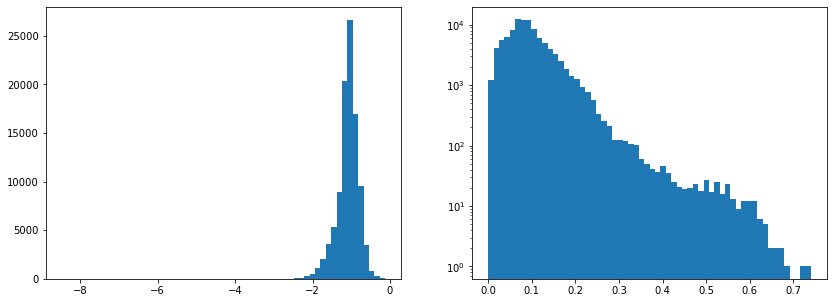

In [36]:
fig,ax = plt.subplots( 1, 2, figsize=(2*7,5))

hbins = 60
ax[0].hist( np.log10(final_push_weights_scaled), bins=hbins)
ax[1].hist( final_push_weights_scaled, bins=hbins)
ax[1].set_yscale('log')

plt.show

In [37]:
selection_mask = final_push_weights_scaled < 100
train_pts_sel = train_pts[ selection_mask ]
weights_sel = final_push_weights_scaled[ selection_mask ]

print(" number of events before selection  %d" % len(train_pts))
print(" number of events passing selection %d" % len(train_pts_sel))
print(" max weight before selection : %f" % np.max(final_push_weights_scaled))
print(" max weight passing selection: %f" % np.max(weights_sel))

 number of events before selection  100000
 number of events passing selection 100000
 max weight before selection : 0.741297
 max weight passing selection: 0.741297


In [38]:
for fi in range( ndim ) :
    
    fit_mean = fit_results_mean_val[fi,si]
    mean_all_evts = all_mean[fi,si]
    mean_sel = ( np.sum( weights_sel * train_pts_sel[:,fi]) ) / ( np.sum( weights_sel ) )
    mean_diff = mean_sel - mean_all_evts
    print(" %2d :  fit mean  %10f   mean all  %10f   selected  %10f   diff %10f  fit diff %10f" % 
          ( fi, fit_mean, mean_all_evts, mean_sel, mean_diff, (mean_sel-fit_mean) ))

  0 :  fit mean    0.206334   mean all    0.206267   selected    0.206267   diff   0.000000  fit diff  -0.000067
  1 :  fit mean    0.804934   mean all    0.805032   selected    0.805032   diff   0.000000  fit diff   0.000098


## Look at outlier point

In [39]:
train_pts_antisel = train_pts[ final_push_weights_scaled > 100 ]
train_pts_antisel.shape

(0, 2)

In [40]:
for fi in range( ndim ) :
    
    sigma = np.sqrt(ave_cov[fi,fi])
    
    print(" %2d :  val %10f   mean %10f   sigma %10f  diff/sigma %10f" %
          (fi, train_pts_antisel[0,fi], ave_mean[fi], sigma, (train_pts_antisel[0,fi]-ave_mean[fi])/sigma )
         )

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
true_sig

## Calculate the true weights and compare with unfolding weights